## Initialization

In [1]:
# prompt: connect to google drive

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


## Constants

In [2]:
PROJECT_ROOT = 'absolute-path-of-project-root'
TRAIN_MBTR_DIR = PROJECT_ROOT + "/data/processed/training_set/features"
TEST_MBTR_DIR = PROJECT_ROOT + "/data/processed/test_set/features"
TRAIN_SASA_DIR = PROJECT_ROOT + "/data/processed/training_set/label"
TEST_SASA_DIR = PROJECT_ROOT + "/data/processed/test_set/label"
MODELS_DIR = PROJECT_ROOT + "/models"
PLOTS_DIR = PROJECT_ROOT + "/plots"
WINDOW_SIZE = 20
SAVE_MODELS = False
RANDOM_STATE = 123

## Imports

In [3]:
import numpy as np
import pandas as pd
import os
from joblib import dump, load
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm
import copy
import keras
from numpy.lib.stride_tricks import sliding_window_view
import random
from sklearn.model_selection import KFold
import pickle
import re
import matplotlib.pyplot as plt

# models
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

## Helper Functions

In [4]:
def evaluate_results(y, y_hat, return_values = False, show_outputs = True):
  if len(y.shape) > 2:
    y = y.reshape((y.shape[0], -1))
    y_hat = y_hat.reshape((y_hat.shape[0], -1))
  mae = mean_absolute_error(y, y_hat)
  mse = mean_squared_error(y, y_hat)
  rmse = mean_squared_error(y, y_hat, squared=False)
  if show_outputs:
    print("MAE: ", mae)
    print("MSE: ", mse)
    print("RMSE: ", rmse)
  if return_values:
    return mae, mse, rmse

In [5]:
def load_model(model_name, num_feature, directory):
    """
    Loads the sepcified model and returns the object representing that model.

    This function is a utility function that loads any of the models used in
    this project. The function reads the model from the specified directory
    through methods applicable to the type of model.

    Parameters
    ----------
    model_name : str
        ``transfomer`` or``ensemble_model``, for simulation part or
        ``sasa_model`` for SASA calculation
    num_feature : int
        Number of features in the training data
    directory : str
        absolute or relative directory for saving the models

    Returns
    -------
    object
        The object of the corresponding model's class
    """
    if model_name == 'transformer' or model_name == 'sasa_model':
        model = keras.models.load_model(directory)
        return model
    elif model_name == 'ensemble':
        model = ensemble_model(num_feature)
        model.load_model(directory)
        return model

In [6]:
TITLES = [
'GEM11',
'GEM41',
'NCL11',
'NHQ51',
'OQL11_3',
'OQL13v2_3',
'PAN11v2_3b',
'PAN14v2_3',
'PAN31_3',
'S1_11R2_3',
'S1_11R4_3',
'S1_15_3'
]
TIMESTEP = 300

def plot_true_and_predicted_sasa(mbtr_model, sasa_model, titles = TITLES, timestep = TIMESTEP, window_size = WINDOW_SIZE):
  x_test, _ = mbtr_ds_generator(TEST_MBTR_DIR)
  y_test = sasa_ds_generator(TEST_SASA_DIR)

  sim_steps = timestep - window_size - 1

  y_pred = []
  y_true = []

  for i in range(12):
    pointer = (i * timestep)
    data = x_test[pointer : pointer + WINDOW_SIZE]
    for j in (range(sim_steps)):
      next_mbtr = mbtr_model.predict(np.expand_dims(data[-window_size:], axis=0))
      data = np.concatenate((data, next_mbtr), axis = 0)
    pred_sasa = sasa_model.predict(np.expand_dims(data[-1], axis = 0))
    pred_sasa = pred_sasa.squeeze()

    plt.scatter(pred_sasa, y_test[(i+1) * timestep - 1])

In [7]:
TITLES = [
'GEM11',
'GEM41',
'NCL11',
'NHQ51',
'OQL11_3',
'OQL13v2_3',
'PAN11v2_3b',
'PAN14v2_3',
'PAN31_3',
'S1_11R2_3',
'S1_11R4_3',
'S1_15_3'
]
TIMESTEP = 300

def calc_error_pc(mbtr_model, sasa_model, titles = TITLES, timestep = TIMESTEP, window_size = WINDOW_SIZE):
  x_test, _ = mbtr_ds_generator(TEST_MBTR_DIR)
  y_test = sasa_ds_generator(TEST_SASA_DIR)

  sim_steps = timestep - window_size - 1

  y_pred = []
  y_true = []

  for i in range(12):
    pointer = (i * timestep)
    data = x_test[pointer : pointer + WINDOW_SIZE]
    for j in (range(sim_steps)):
      next_mbtr = mbtr_model.predict(np.expand_dims(data[-window_size:], axis=0))
      data = np.concatenate((data, next_mbtr), axis = 0)
    pred_sasa = sasa_model.predict(np.expand_dims(data[-1], axis = 0))
    pred_sasa = pred_sasa.squeeze()
    y_pred.append(pred_sasa)
    y_true.append(y_test[(i+1) * timestep - 1])

  return mean_absolute_error(y_true, y_pred)

In [8]:
TITLES = [
'GEM11',
'GEM41',
'NCL11',
'NHQ51',
'OQL11_3',
'OQL13v2_3',
'PAN11v2_3b',
'PAN14v2_3',
'PAN31_3',
'S1_11R2_3',
'S1_11R4_3',
'S1_15_3'
]
TIMESTEP = 300

def calc_error_mbtr(mbtr_model, timestep = TIMESTEP, window_size = WINDOW_SIZE):
  x_test, _ = mbtr_ds_generator(TEST_MBTR_DIR)

  error = 0
  sim_steps = timestep - window_size - 1
  y_pred = []
  y_true = []

  for i in range(12):
    pointer = (i * timestep)
    data = x_test[pointer : pointer + WINDOW_SIZE]
    for j in (range(sim_steps)):
      next_mbtr = mbtr_model.predict(np.expand_dims(data[-window_size:], axis=0))
      data = np.concatenate((data, next_mbtr), axis = 0)
    y_pred.append(data[-1])
    y_true.append(x_test[(i+1) * timestep - 1])

    # error = error + np.sum(np.abs(data[-1] - x_test[(i+1) * timestep - 1]))

  return mean_absolute_error(y_true, y_pred), mean_squared_error(y_true, y_pred, squared=False)

## Load Data

In [9]:
def mbtr_ds_generator(directory):
  """
  Creates a dataset of the MBTR vectors.

  This function reads all CSV data files containing MBTR vectors
  generated from data of different design configurations. All the
  vectors are gathered in a dataset along with the duration of the
  simulations for the designs.

  Parameters
  ----------
  directory : str
      absolute or relative directory of the MBTR CSV datasets

  Returns
  -------
  x : array of floats; shape (number of designs * duration, num_feature)
      The vector array of all the MBTRs in a sequence stacked row-wise
  timestep_size : list of int
      duration of each design for the MBTR files in the directory
  """
  ptr = 0
  timestep_size = []
  if directory[-1] != '/':
    directory = directory + '/'
  for mbtr_file in sorted(os.listdir(directory)):
    x_mbtr = pd.read_csv(directory + str(mbtr_file))
    timestep_size.append(x_mbtr.shape[0])
    if ptr == 0:
      x = np.array(x_mbtr.values.tolist())
      ptr = 1
    else:
      x = np.concatenate((x, np.array(x_mbtr.values.tolist())), axis = 0)
    # print("MBTR: ", mbtr_file, "Shape:", x.shape)

  # print("MBTR Shape:", x.shape)
  # print("timesteps: ", len(timestep_size))
  return x, timestep_size

def sasa_ds_generator(directory):
  """
  Creates a dataset of SASA values.

  This function reads all CSV data files containing the SASA values
  corresponding to different design configurations at different states.
  All the values are gathered in a dataset.

  Parameters
  ----------
  directory : str
      absolute or relative directory of the SASA CSV datasets

  Returns
  -------
  array of floats; shape (number of designs * duration,)
      The array of all the SASA values in a sequence stacked row-wise
  """
  ptr = 0
  if directory[-1] != '/':
    directory = directory + '/'
  for sasa_file in sorted(os.listdir(directory)):
    # print("SASA: ", sasa_file)
    x_sasa = pd.read_csv(directory + str(sasa_file), sep=';')
    if ptr == 0:
          x = np.array(x_sasa['TOTAL'])
          ptr = 1
    else:
          x = np.concatenate((x, np.array(x_sasa['TOTAL'])), axis = 0)
  # print("SASA Shape:", x.shape)
  return x

def mbtr_mbtr_ds_generator(directory, window_size, sasa_dir = None, shuffle = False):
  """
  Creates a windowed dataset of the MBTR vectors, and SASA values if specified.

  This function reads all CSV data files containing MBTR vectors
  generated from data of different design configurations. Then,
  generates a sliding window based dataset pair of MBTRs. If specified
  the SASA values are also recorded.

  Parameters
  ----------
  directory : str
      absolute or relative directory of the MBTR CSV datasets
  window_size: int
      The window size to create the data pairs
  sasa_dir : str or None; default: None
      absolute or relative directory of the SASA CSV datasets,
      if ``None`` SASA values are not considered
  shuffle : bool
      Used to decide whether or not to shuffle the data order

  Returns
  -------
  dataset_x : array of floats; shape (number of samples, window_size, num_feature)
      The vector array of all the MBTRs stacked in sliding window method
  dataset_y : array of floats; shape (number of samples, num_feature)
      The array of MBTR vectors of the next timesteps of the window
  y_sasa : arrary of floats;  shape (number of samples, 1)
      The array of all the SASA values for the next timesteps of the window
  sasa_zero : array of float; shape (number of designs, 1)
      The array of initial SASA values (1st timestep) for each design configuration
  """
  dataset_x = []
  dataset_y = []
  y_sasa = []
  sasa_zero = []
  i = 0
  j = 0
  mbtr, timestep_size = mbtr_ds_generator(directory)
  if sasa_dir is not None:
    sasa = sasa_ds_generator(sasa_dir)
    if shuffle == True:
      idx = np.arange(mbtr.shape[0])
      np.random.shuffle(idx)
      mbtr = mbtr[idx]
      sasa = sasa[idx]
    assert mbtr.shape[0] == sasa.shape[0], "MBTR and SASA have mismatching shapes"
  elif shuffle == True:
    np.random.shuffle(mbtr)

  for i in range(len(timestep_size)):
    if i == 0:
        z = 0
    else:
        z = sum(timestep_size[:i])
    for j in range(z, z + timestep_size[i] - window_size):
      dataset_x.append(mbtr[j : j + window_size])
      dataset_y.append(mbtr[j + window_size])
      if not sasa_dir is None:
        y_sasa.append(sasa[j + window_size])
    if not sasa_dir is None:
      sasa_zero.append(sasa[z])
  if not sasa_dir is None:
    return np.array(dataset_x), np.array(dataset_y), np.array(y_sasa), np.array(sasa_zero)
  return np.array(dataset_x), np.array(dataset_y)

def get_X_predicted_and_y(mbtr_model):
  X, timesteps = mbtr_ds_generator(TRAIN_MBTR_DIR)
  Y = sasa_ds_generator(TRAIN_SASA_DIR)
  X_predicted = []
  labels = []
  for i in range(len(timesteps)):
    start = sum(timesteps[:i])
    end = start + timesteps[i] - 1
    current_data = X[start:start+WINDOW_SIZE]
    current_position = start + WINDOW_SIZE
    while current_position < end:
      X_predicted.append(mbtr_model.predict(np.expand_dims(current_data, axis=0)))
      labels.append(Y[current_position])
      current_data = np.concatenate((current_data[1:], X_predicted[-1]), axis=0)
      current_position = current_position + 1
  return np.array(X_predicted), np.array(labels)

## Train models

In [10]:
x_train, y_train, y_sasa_train, sasa_zero_train = mbtr_mbtr_ds_generator(TRAIN_MBTR_DIR, window_size = WINDOW_SIZE, sasa_dir=TRAIN_SASA_DIR, shuffle = False)
x_test, y_test, y_sasa_test, sasa_zero_test = mbtr_mbtr_ds_generator(TEST_MBTR_DIR, window_size = WINDOW_SIZE, sasa_dir=TEST_SASA_DIR, shuffle = False)
# y_train = sasa_ds_generator(TRAIN_SASA_DIR)
# y_test = sasa_ds_generator(TEST_SASA_DIR)
x_train.shape, y_train.shape, y_sasa_train.shape, x_test.shape, y_test.shape, y_sasa_test.shape

((22620, 20, 72), (22620, 72), (22620,), (3360, 20, 72), (3360, 72), (3360,))

In [11]:
x_train.std()

2913.2889247766525

In [12]:
x_train_standardized = (x_train - x_train.mean()) / x_train.std()
x_test_standardized = (x_test - x_train.mean()) / x_train.std()
x_train_standardized.shape, x_test_standardized.shape

((22620, 20, 72), (3360, 20, 72))

### MBTR Training

#### Train different machine learning models

In [ ]:
class ensemble_model_custome():
  """
  Customized version of ensemble_model class

  This class handles functions such as training, predicting, evaluating,
  etc. presenting the object of a class as a single model.

  Attributes
  ----------
  models : list of models
      List of models in order representing each feature; initialized or trained
  num_feature : int
      Number of features in the training data

  Methods
  -------
  train(x, y):
      Loops through and Trains all the models
  predict(test_sample):
      Predicts the outcome, through the trained models
  evaluate(x, y):
      Calculates the Mean Absolute Error for given data
  save(directory):
      Saves the models into specified dirctory
  load_model(directory):
      Loads the models from specified directory
  """

  def __init__(self, num_feature, model, model_name, models_dir=MODELS_DIR):
    """
    Constructs all the necessary attributes for the model object.

    This function creates one model for the specified number
    of features each and initializes a list of the models in order.

    Parameters
    ----------
    num_feature : int
        Number of features in the training data
    model: class
        The model class to be used
    model_name: str
        The name of the model
    models_dir: str
        The directory where the models are stored or should be stored
    """
    self.models = []
    self.models_dir = models_dir
    self.num_feature = num_feature
    self.model_name = model_name
    for i in range(self.num_feature):
      current_model = model()
      if hasattr(current_model, 'random_state'):
        setattr(current_model, 'random_state', RANDOM_STATE)
      self.models.append(current_model)

  def train(self, x, y):
    """
    Loops through and Trains all the models

    Reads each model from the models attribute, takes only the data for
    the feature corresponding to the model, and trains the model.

    Parameters
    ----------
    x : array of float; shape (number of samples, window_size, num_feature)
        Windowed training data.
    y : array of float; shape (number of samples, num_feature)
        Training Label Vector
    """
    for i in tqdm(range(self.num_feature)):
      x_t = [x[j,:,i] for j in range(x.shape[0])]
      y_t = [y[j][i] for j in range(y.shape[0])]
      self.models[i].fit(x_t, y_t)

  def predict(self, test_sample):
    """
    Predicts the outcome, through the trained models

    Reads each model from the models attribute, takes only the data for
    feature corresponding to the model, and predicts the outcome for that
    feature. The whole vector is collected in a list.

    Parameters
    ----------
    test_sample : array of float; shape (number of samples, window_size, num_feature)
        Windowed data for prediction

    Returns
    -------
    Array of float; shape (1, num_feature)
        The whole vector of prediction for the passed sample
    """
    pred = None
    for i in range(self.num_feature):
      x_t = test_sample[:, :, i]
      prediction = np.expand_dims(self.models[i].predict((x_t)), axis=1)
      if not isinstance(pred, np.ndarray):
        pred = prediction
      else:
        pred = np.concatenate((pred, prediction), axis=1)
    return pred

  def get_model_directory(self):
    """
    Returns models' directory

    Parameters
    ----------
    None

    Returns
    -------
    string
        The path of the directory where the models are stored
    """
    path = self.models_dir
    if path[-1] != '/':
        path = path + '/'
    path = path + self.model_name + str(WINDOW_SIZE) + '/'
    return path

  def get_sub_model_path(self, idx):
    """
    Returns the path of sub models

    Gets the directory of the sub models, and then returns the path of a specified
    sub model.

    Parameters
    ----------
    idx : integer
        The index of the sub model

    Returns
    -------
    string
        The path of the sub model
    """
    return self.get_model_directory() + str(idx) + '.pkl'

  def model_exists(self):
    """
    Returns true if the model exists, otherwise returns false

    Parameters
    ----------
    None

    Returns
    -------
    Boolean
        True if the model exists, otherwise false
    """
    path = self.get_model_directory()
    return os.path.exists(path)

  def save(self, overwrite=False):
    """
    Saves the models from the models attribute into specified dirctory.

    Parameters
    ----------
    overwrite : Boolean
        True if the models should be overwritten
    """
    if overwrite == False:
      assert not self.model_exists()
      os.makedirs(self.get_model_directory())

    for i in range(self.num_feature):
      pickle.dump(self.models[i], open(self.get_sub_model_path(i), 'wb'))

  def load_model(self):
    """
    Loads the models from specified dirctory and updates the models attribute.

    Parameters
    ----------
    None
    """

    if not self.model_exists():
      raise Exception("Model does not exist")

    self.models = []
    for i in range(self.num_feature):
      model = pickle.load(open(self.get_sub_model_path(i), 'rb'))
      self.models.append(model)

In [ ]:
models = [LinearRegression,
          XGBRegressor,
          AdaBoostRegressor,
          GradientBoostingRegressor,
          ExtraTreesRegressor,
          SVR,
          KNeighborsRegressor,
          DecisionTreeRegressor,
          RandomForestRegressor]
models_names = ['LR',
                'XGB',
                'AdaBoost',
                'GBM',
                'ETR',
                'SVR',
                'KNR',
                'DTR',
                'RFR']
assert len(models) == len(models_names)

In [ ]:
indices = list(range(len(x_train)))
random.Random(RANDOM_STATE).shuffle(indices)
for i in range(len(models)):
  model = ensemble_model_custome(72, models[i], models_names[i])

  print("Model Name: ", models_names[i])

  if model.model_exists():
    model.load_model()
  else:
    model.train(x_train[indices], y_train[indices])

  print("Train set: ")
  evaluate_results(model.predict(x_train), y_train)
  print("Test set: ")
  evaluate_results(model.predict(x_test), y_test)
  print("Test set error of last timestep: ", calc_error_mbtr(model))

  if not model.model_exists() and SAVE_MODELS == True:
    model.save()

  print("-----------------------------\n")

Model Name:  LR
Train set: 
MAE:  1.2098185912826946
MSE:  34.26985639602534
RMSE:  1.5612016363481815
Test set: 
MAE:  1.2090176930991678
MSE:  34.298422130259375
RMSE:  1.5535491622494044
Test set error of last timestep:  (5.172987837500628, 6.070042403732843)
-----------------------------

Model Name:  XGB


100%|██████████| 72/72 [00:48<00:00,  1.48it/s]


Train set: 
MAE:  1.1485300980276112
MSE:  36.29107401588115
RMSE:  1.5671205863926876
Test set: 
MAE:  1.5724667982390792
MSE:  50.46511739732138
RMSE:  2.4087625721926034
Test set error of last timestep:  (9.175079720128771, 12.087796287498476)
-----------------------------

Model Name:  AdaBoost


100%|██████████| 72/72 [04:34<00:00,  3.82s/it]


Train set: 
MAE:  9.713203828369636
MSE:  2763.967479626347
RMSE:  12.29340217752573
Test set: 
MAE:  8.916482401900147
MSE:  2066.6978377678565
RMSE:  11.283093677872364
Test set error of last timestep:  (18.495860421380264, 26.999720215023082)
-----------------------------

Model Name:  GBM


100%|██████████| 72/72 [12:45<00:00, 10.63s/it]


Train set: 
MAE:  1.426905299960294
MSE:  51.3277879082313
RMSE:  1.85410467849107
Test set: 
MAE:  1.8588439446766643
MSE:  76.8014787125065
RMSE:  2.825212370796406
Test set error of last timestep:  (9.253754476640653, 12.152976275550119)
-----------------------------

Model Name:  ETR


100%|██████████| 72/72 [08:12<00:00,  6.84s/it]


Train set: 
MAE:  2.9132879497270765e-06
MSE:  2.9232529025396125e-08
RMSE:  4.0739726864293036e-05
Test set: 
MAE:  1.1968052200069175
MSE:  34.73905364632387
RMSE:  1.664624114223645
Test set error of last timestep:  (7.074920451302087, 9.720341336841885)
-----------------------------

Model Name:  SVR


100%|██████████| 72/72 [10:11<00:00,  8.49s/it]


Train set: 
MAE:  31.98081893788423
MSE:  238677.16690227218
RMSE:  101.9014890298346
Test set: 
MAE:  5.697347517300926
MSE:  4993.646156612467
RMSE:  12.297853478576668
Test set error of last timestep:  (23.324373908849125, 31.508076037549383)
-----------------------------

Model Name:  KNR


100%|██████████| 72/72 [00:04<00:00, 15.02it/s]


Train set: 
MAE:  1.09991321258446
MSE:  28.400370832145043
RMSE:  1.419873347453004
Test set: 
MAE:  1.697576685851331
MSE:  61.888154269779484
RMSE:  2.6935560352574464
Test set error of last timestep:  (7.912466121526888, 10.387005146699236)
-----------------------------

Model Name:  DTR


100%|██████████| 72/72 [00:36<00:00,  1.95it/s]


Train set: 
MAE:  2.9191316910421352e-06
MSE:  2.9232532665290905e-08
RMSE:  4.0749330255612367e-05
Test set: 
MAE:  1.9477353969785298
MSE:  86.7231869750534
RMSE:  3.1004780414761033
Test set error of last timestep:  (6.6776119505219524, 9.22273034573781)
-----------------------------

Model Name:  RFR


100%|██████████| 72/72 [34:06<00:00, 28.42s/it]


Train set: 
MAE:  0.46465287889741386
MSE:  5.14358494355245
RMSE:  0.6043130660837654
Test set: 
MAE:  1.4397135342310645
MSE:  47.74801563388965
RMSE:  2.3396598409457052
Test set error of last timestep:  (8.132979418248661, 10.866115673959294)
-----------------------------



### SASA Training

#### Train different machine learning models

In [13]:
class ensemble_model_custome():
  """
  Customized version of ensemble_model class

  This class handles functions such as training, predicting, evaluating,
  etc. presenting the object of a class as a single model.

  Attributes
  ----------
  models : list of models
      List of models in order representing each feature; initialized or trained
  num_feature : int
      Number of features in the training data

  Methods
  -------
  train(x, y):
      Loops through and Trains all the models
  predict(test_sample):
      Predicts the outcome, through the trained models
  evaluate(x, y):
      Calculates the Mean Absolute Error for given data
  save(directory):
      Saves the models into specified dirctory
  load_model(directory):
      Loads the models from specified directory
  """

  def __init__(self, num_feature, model, model_name, models_dir=MODELS_DIR):
    """
    Constructs all the necessary attributes for the model object.

    This function creates one model for the specified number
    of features each and initializes a list of the models in order.

    Parameters
    ----------
    num_feature : int
        Number of features in the training data
    model: class
        The model class to be used
    model_name: str
        The name of the model
    models_dir: str
        The directory where the models are stored or should be stored
    """
    self.models = []
    self.models_dir = models_dir
    self.num_feature = num_feature
    self.model_name = model_name
    for i in range(self.num_feature):
      current_model = model()
      if hasattr(current_model, 'random_state'):
        setattr(current_model, 'random_state', RANDOM_STATE)
      self.models.append(current_model)

  def train(self, x, y):
    """
    Loops through and Trains all the models

    Reads each model from the models attribute, takes only the data for
    the feature corresponding to the model, and trains the model.

    Parameters
    ----------
    x : array of float; shape (number of samples, window_size, num_feature)
        Windowed training data.
    y : array of float; shape (number of samples, num_feature)
        Training Label Vector
    """
    for i in tqdm(range(self.num_feature)):
      x_t = [x[j,:,i] for j in range(x.shape[0])]
      y_t = [y[j][i] for j in range(y.shape[0])]
      self.models[i].fit(x_t, y_t)

  def predict(self, test_sample):
    """
    Predicts the outcome, through the trained models

    Reads each model from the models attribute, takes only the data for
    feature corresponding to the model, and predicts the outcome for that
    feature. The whole vector is collected in a list.

    Parameters
    ----------
    test_sample : array of float; shape (number of samples, window_size, num_feature)
        Windowed data for prediction

    Returns
    -------
    Array of float; shape (1, num_feature)
        The whole vector of prediction for the passed sample
    """
    pred = None
    for i in range(self.num_feature):
      x_t = test_sample[:, :, i]
      prediction = np.expand_dims(self.models[i].predict((x_t)), axis=1)
      if not isinstance(pred, np.ndarray):
        pred = prediction
      else:
        pred = np.concatenate((pred, prediction), axis=1)
    return pred

  def get_model_directory(self):
    """
    Returns models' directory

    Parameters
    ----------
    None

    Returns
    -------
    string
        The path of the directory where the models are stored
    """
    path = self.models_dir
    if path[-1] != '/':
        path = path + '/'
    path = path + self.model_name + str(WINDOW_SIZE) + '/'
    return path

  def get_sub_model_path(self, idx):
    """
    Returns the path of sub models

    Gets the directory of the sub models, and then returns the path of a specified
    sub model.

    Parameters
    ----------
    idx : integer
        The index of the sub model

    Returns
    -------
    string
        The path of the sub model
    """
    return self.get_model_directory() + str(idx) + '.pkl'

  def model_exists(self):
    """
    Returns true if the model exists, otherwise returns false

    Parameters
    ----------
    None

    Returns
    -------
    Boolean
        True if the model exists, otherwise false
    """
    path = self.get_model_directory()
    return os.path.exists(path)

  def save(self, overwrite=False):
    """
    Saves the models from the models attribute into specified dirctory.

    Parameters
    ----------
    overwrite : Boolean
        True if the models should be overwritten
    """
    if overwrite == False:
      assert not self.model_exists()
      os.makedirs(self.get_model_directory())

    for i in range(self.num_feature):
      pickle.dump(self.models[i], open(self.get_sub_model_path(i), 'wb'))

  def load_model(self):
    """
    Loads the models from specified dirctory and updates the models attribute.

    Parameters
    ----------
    None
    """

    if not self.model_exists():
      raise Exception("Model does not exist")

    self.models = []
    for i in range(self.num_feature):
      model = pickle.load(open(self.get_sub_model_path(i), 'rb'))
      self.models.append(model)

LR_MBTR = ensemble_model_custome(72, LinearRegression, 'LR')
LR_MBTR.load_model()

In [14]:
models = [LinearRegression,
          ExtraTreesRegressor,
          XGBRegressor,
          AdaBoostRegressor,
          GradientBoostingRegressor,
          SVR,
          KNeighborsRegressor,
          DecisionTreeRegressor,
          RandomForestRegressor]
models_names = ['LR',
                'ETR',
                'XGB',
                'AdaBoost',
                'GBM',
                'SVR',
                'KNR',
                'DTR',
                'RFR']
assert len(models) == len(models_names)

##### Train with original MBTR values

In [15]:
idx = dict([(1, 0), (2, 2), (5, 4), (10, 6), (20, 8), (30, 10), (40, 12)])
df1 = pd.read_csv(PROJECT_ROOT + "/results/original-data-mae-rmse.csv")
df2 = pd.read_csv(PROJECT_ROOT + "/results/original-data-pc.csv")

indices = list(range(len(y_train)))
random.Random(RANDOM_STATE).shuffle(indices)
for i in range(len(models)):
  model = models[i]()
  print("Model Name: ", models_names[i])

  if hasattr(model, 'random_state'):
    setattr(model, 'random_state', RANDOM_STATE)

  model.fit(y_train[indices], y_sasa_train[indices])
  print("Train set: ")
  evaluate_results(model.predict(y_train), y_sasa_train)
  print("Test set: ")
  mae, mse, rmse = evaluate_results(model.predict(y_test), y_sasa_test, return_values=True)
  pc_error = calc_error_pc(LR_MBTR, model)
  print("Test set pc error: ", pc_error)
  df1[models_names[i]][idx[WINDOW_SIZE]] = mae
  df1[models_names[i]][idx[WINDOW_SIZE]+1] = rmse
  df2[models_names[i]][idx[WINDOW_SIZE]] = pc_error
  print("-----------------------------\n")

df1.to_csv(PROJECT_ROOT + "/results/original-data-mae-rmse.csv", index=False)
df2.to_csv(PROJECT_ROOT + "/results/original-data-pc.csv", index=False)

Model Name:  LR
Train set: 
MAE:  917.7882948761129
MSE:  1393364.4340289296
RMSE:  1180.4085877478738
Test set: 
MAE:  920.0588363470197
MSE:  1316921.8692055354
RMSE:  1147.57216296211
Test set pc error:  3842.904445625653
-----------------------------

Model Name:  ETR
Train set: 
MAE:  0.0
MSE:  0.0
RMSE:  0.0
Test set: 
MAE:  1121.0729361630395
MSE:  2695811.365787209
RMSE:  1641.8926170085574
Test set pc error:  2733.561484375001
-----------------------------

Model Name:  XGB
Train set: 
MAE:  539.4289207127956
MSE:  492967.65326962253
RMSE:  702.1165524822944
Test set: 
MAE:  1646.3412574404763
MSE:  5494754.222375706
RMSE:  2344.089209560017
Test set pc error:  2948.919921875
-----------------------------

Model Name:  AdaBoost
Train set: 
MAE:  4100.006808924391
MSE:  24074143.616967674
RMSE:  4906.540901385381
Test set: 
MAE:  4146.944784189675
MSE:  26010108.731905494
RMSE:  5100.010659979594
Test set pc error:  4755.238862929334
-----------------------------

Model Name:  

##### Train with predicted MBTR values

In [16]:
X_sasa, Y_sasa = get_X_predicted_and_y(LR_MBTR)

In [17]:
X_sasa = X_sasa.squeeze()

In [18]:
X_sasa.shape, Y_sasa.shape

((22513, 72), (22513,))

In [ ]:
indices = list(range(len(X_sasa)))
random.Random(RANDOM_STATE).shuffle(indices)
for i in range(len(models)):
  model = models[i]()
  print("Model Name: ", models_names[i])

  if hasattr(model, 'random_state'):
    setattr(model, 'random_state', RANDOM_STATE)

  model.fit(X_sasa[indices], Y_sasa[indices])
  print("Predicted train set: ")
  evaluate_results(model.predict(X_sasa), Y_sasa)
  print("Train set: ")
  evaluate_results(model.predict(y_train), y_sasa_train)
  print("Test set: ")
  evaluate_results(model.predict(y_test), y_sasa_test)
  print("Test set pc error: ", calc_error_pc(LR_MBTR, model))
  print("-----------------------------\n")

Model Name:  LR
Predicted train set: 
MAE:  1417.4270057673116
MSE:  3327645.8327528737
RMSE:  1824.1836071933312
Train set: 
MAE:  6913.579067659889
MSE:  2648496517.428068
RMSE:  51463.54551940692
Test set: 
MAE:  12473.132163974313
MSE:  8165167677.042614
RMSE:  90361.31737111082
Test set pc error:  3580.164261139962
-----------------------------

Model Name:  ETR
Predicted train set: 
MAE:  0.0
MSE:  0.0
RMSE:  0.0
Train set: 
MAE:  3896.945261334946
MSE:  25695247.564837776
RMSE:  5069.0479939371035
Test set: 
MAE:  3945.339506452288
MSE:  24651591.205944523
RMSE:  4965.03687860871
Test set pc error:  1807.7116178385415
-----------------------------

Model Name:  XGB
Predicted train set: 
MAE:  585.240397887297
MSE:  565258.9510005383
RMSE:  751.8370508298578
Train set: 
MAE:  4820.3094392623025
MSE:  46125040.488399334
RMSE:  6791.54183439956
Test set: 
MAE:  4592.800970749628
MSE:  31958408.48242446
RMSE:  5653.176848677605
Test set pc error:  2234.3304036458335
----------------

##### Train with original + predicted MBTR values

In [19]:
idx = dict([(1, 0), (2, 2), (5, 4), (10, 6), (20, 8), (30, 10), (40, 12)])
df1 = pd.read_csv(PROJECT_ROOT + "/results/all-data-mae-rmse.csv")
df2 = pd.read_csv(PROJECT_ROOT + "/results/all-data-pc.csv")

all_X = np.concatenate((X_sasa, y_train), axis=0)
all_y = np.concatenate((Y_sasa, y_sasa_train), axis=0)
print(all_X.shape, all_y.shape)
indices = list(range(len(all_X)))
random.Random(RANDOM_STATE).shuffle(indices)
for i in range(len(models)):
  model = models[i]()
  print("Model Name: ", models_names[i])

  if hasattr(model, 'random_state'):
    setattr(model, 'random_state', RANDOM_STATE)

  model.fit(all_X[indices], all_y[indices])
  print("Predicted train set: ")
  evaluate_results(model.predict(X_sasa), Y_sasa)
  print("Train set: ")
  evaluate_results(model.predict(y_train), y_sasa_train)
  print("Test set: ")
  mae, mse, rmse = evaluate_results(model.predict(y_test), y_sasa_test, return_values=True)
  pc_error = calc_error_pc(LR_MBTR, model)
  print("Test set pc error: ", pc_error)
  df1[models_names[i]][idx[WINDOW_SIZE]] = mae
  df1[models_names[i]][idx[WINDOW_SIZE]+1] = rmse
  df2[models_names[i]][idx[WINDOW_SIZE]] = pc_error
  print("-----------------------------\n")

df1.to_csv(PROJECT_ROOT + "/results/all-data-mae-rmse.csv", index=False)
df2.to_csv(PROJECT_ROOT + "/results/all-data-pc.csv", index=False)

(45133, 72) (45133,)
Model Name:  LR
Predicted train set: 
MAE:  1715.84623499828
MSE:  4776337.971890083
RMSE:  2185.4834641081325
Train set: 
MAE:  1170.6264578146058
MSE:  2700850.8244240945
RMSE:  1643.4265497502754
Test set: 
MAE:  1170.104520968735
MSE:  2403652.4272909476
RMSE:  1550.3717061695068
Test set pc error:  2328.2632500924906
-----------------------------

Model Name:  ETR
Predicted train set: 
MAE:  0.0
MSE:  0.0
RMSE:  0.0
Train set: 
MAE:  0.0
MSE:  0.0
RMSE:  0.0
Test set: 
MAE:  1091.5401485072543
MSE:  2634080.415275206
RMSE:  1622.9850323632704
Test set pc error:  1447.593541666667
-----------------------------

Model Name:  XGB
Predicted train set: 
MAE:  688.0717114746897
MSE:  775918.7784365899
RMSE:  880.8625196003005
Train set: 
MAE:  659.435961460751
MSE:  748389.0817960756
RMSE:  865.0948397696495
Test set: 
MAE:  1503.4194731212797
MSE:  4381625.604462569
RMSE:  2093.233289545761
Test set pc error:  2198.2845052083335
-----------------------------

Model

#### Plotting the performance

In [ ]:
mbtr_model = LR_MBTR
sasa_model = ExtraTreesRegressor(random_state=RANDOM_STATE).fit(all_X, all_y)

In [ ]:
mem = []

In [ ]:
TITLES = [
'GEM11',
'GEM41',
'NCL11',
'NHQ51',
'OQL11_3',
'OQL13v2_3',
'PAN11v2_3b',
'PAN14v2_3',
'PAN31_3',
'S1_11R2_3',
'S1_11R4_3',
'S1_15_3'
]
TIMESTEP = 300

def plot_true_and_predicted_sasa(mbtr_model, sasa_model, titles = TITLES, timestep = TIMESTEP, window_size = WINDOW_SIZE):
  x_test, _ = mbtr_ds_generator(TEST_MBTR_DIR)
  y_test = sasa_ds_generator(TEST_SASA_DIR)

  sim_steps = timestep - window_size - 1

  y_pred = []
  y_true = []

  print("NAME", "PRED", "TRUE")

  for i in range(12):
    if len(mem) <= i:
      pointer = (i * timestep)
      data = x_test[pointer : pointer + WINDOW_SIZE]
      for j in (range(sim_steps)):
        next_mbtr = mbtr_model.predict(np.expand_dims(data[-window_size:], axis=0))
        data = np.concatenate((data, next_mbtr), axis = 0)
      pred_sasa = sasa_model.predict(np.expand_dims(data[-1], axis = 0))
      pred_sasa = pred_sasa.squeeze()
      mem.append(pred_sasa)
    else:
      pred_sasa = mem[i]

    print(titles[i], pred_sasa, y_test[(i+1) * timestep - 1])

    plt.scatter(pred_sasa, y_test[(i+1) * timestep - 1])

  plt.legend(titles)

  plt.xlabel('Predicted SASA')
  plt.ylabel('True SASA')
  plt.axline((60000,60000), slope=1, linestyle='--', color='black')
  plt.savefig(PLOTS_DIR + "/sasa_true_vs_pred_" + str(WINDOW_SIZE) + ".png", dpi=300)
  plt.show()

NAME PRED TRUE
GEM11 74377.7078125 74784.6875
GEM41 81983.65421875 80337.0703125
NCL11 67413.284609375 63675.27734375
NHQ51 60736.6014453125 60745.85546875
OQL11_3 67025.966171875 66567.953125
OQL13v2_3 73508.79546875 75432.515625
PAN11v2_3b 73945.3359375 74523.9375
PAN14v2_3 75293.8013671875 76080.1484375
PAN31_3 78310.803359375 82504.890625
S1_11R2_3 67345.238984375 68690.3203125
S1_11R4_3 67054.7205859375 64980.51953125
S1_15_3 74860.0116796875 75070.2578125


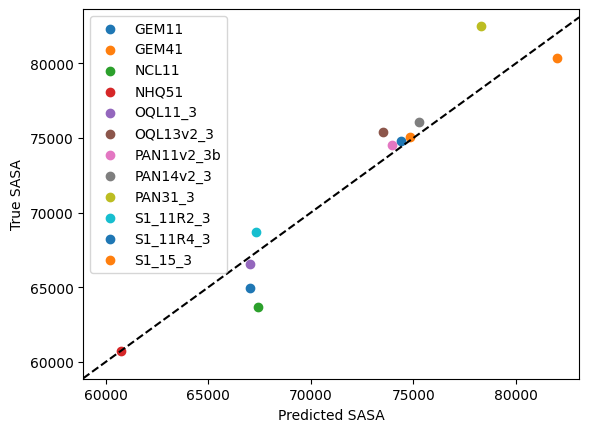

In [ ]:
plot_true_and_predicted_sasa(mbtr_model, sasa_model)